In [1]:
!pip install ipynb

/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified


/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [5/50] Batch 781/782                   Loss Discriminator: 1.671, loss Generator: 2.342, FID Score: 287.811 
Epoch [10/50] Batch 781/782                   Loss Discriminator: 0.893, loss Generator: 4.656, FID Score: 329.048 
Epoch [15/50] Batch 781/782                   Loss Discriminator: 1.110, loss Generator: 5.824, FID Score: 309.500 
Epoch [20/50] Batch 781/782                   Loss Discriminator: 0.829, loss Generator: 6.018, FID Score: 330.870 
Epoch [25/50] Batch 781/782                   Loss Discriminator: 0.613, loss Generator: 8.686, FID Score: 332.389 
Epoch [30/50] Batch 781/782                   Loss Discriminator: 0.621, loss Generator: 7.748, FID Score: 308.908 
Epoch [35/50] Batch 781/782                   Loss Discriminator: 0.539, loss Generator: 8.843, FID Score: 286.005 
Epoch [40/50] Batch 781/782                   Loss Discriminator: 0.831, loss Generator: 8.486, FID Score: 307.675 
Epoch [45/50] Batch 781/782                   Loss Discriminator: 0.910, 

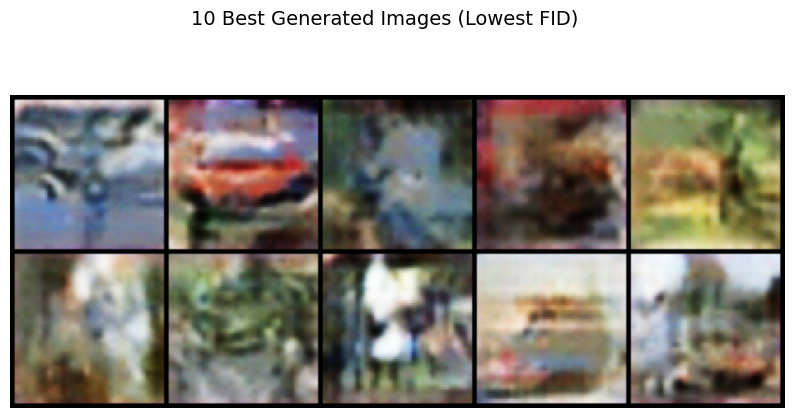

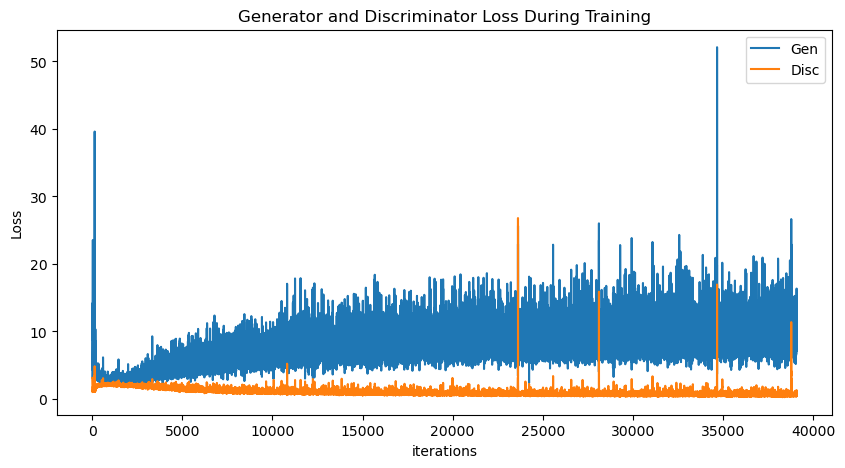

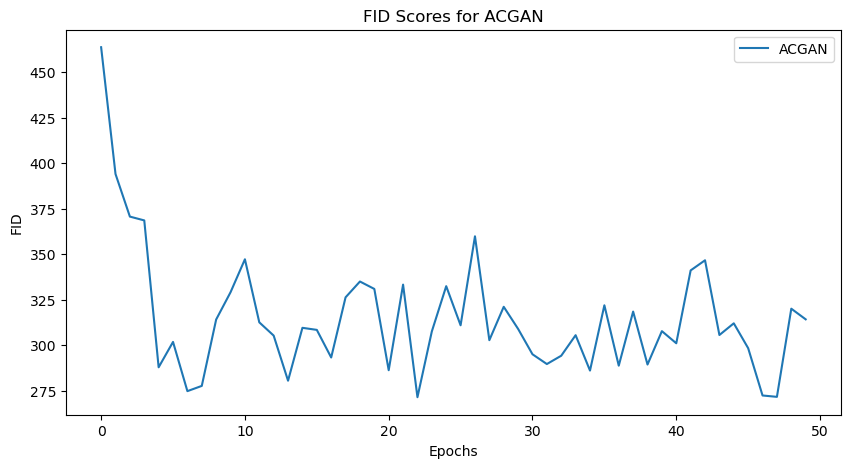

In [2]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd
from ipynb.fs.full.FID import calculate_fretchet


torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 2e-4
BATCH_SIZE = 64
image_size = 64
channels_img = 3  
noise_dim = 100
max_epochs = 50
disc_features = 64 
gen_features = 64 
num_classes = 10
embed_size = 100
criticItr = 5


dataset = datasets.CIFAR10(root="./dataset/CIFAR10", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]),
                           ]))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)



class Generator(nn.Module):
    def __init__(self, num_classes, img_size,embed_size,channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            nn.ConvTranspose2d(noise_dim+embed_size,features_g* 16, 4, 1, 0, bias = False),   
            self.block(features_g * 16, features_g * 8, 4, 2, 1),  
            self.block(features_g * 8, features_g * 4, 4, 2, 1),  
            self.block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
        
        self.embed = nn.Embedding(num_classes, embed_size)

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False,),
            nn.BatchNorm2d(out_channels,momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.net(x)
    

    
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size,channels_img, features_d):    
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self.block(features_d, features_d * 2, 4, 2, 1),      
            self.block(features_d * 2, features_d * 4, 4, 2, 1),  
            self.block(features_d * 4, features_d * 8, 4, 2, 1),
        )
        self.validity_layer = nn.Sequential(
            nn.Conv2d(512,1,4,1,0,bias = False),
                               nn.Sigmoid())
        
        self.labels = nn.Sequential(
            nn.Conv2d(512, 11, 4, 1, 0, bias = False), 
            nn.LogSoftmax(dim = 1)
                                        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)
        
        

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False,),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        x = self.disc(x)
        valid = self.validity_layer(x).view(-1)
        label = self.labels(x).view(-1,11)
        return valid,label
    

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            
            
gen = Generator(num_classes, image_size,embed_size,noise_dim, channels_img, gen_features).to(device)
disc = Discriminator(num_classes, image_size,channels_img, disc_features).to(device)
initialize_weights(gen)
initialize_weights(disc)



fixed_noise = torch.randn(32, noise_dim, 1, 1).to(device)
fixed_labels = torch.arange(0, num_classes).repeat(4)[:32].to(device)
step = 0
disOptim = optim.Adam(disc.parameters(),learning_rate, betas = (0.5,0.999))
genOptim = optim.Adam(gen.parameters(), learning_rate, betas = (0.5,0.999))
criterion = nn.BCELoss()
counterList = []
counter = 0
genLossList = []
disLossList = []
img_list = []



gen.train() 
disc.train()
GenLoss = []
DiscLoss = []
img_list = []
iters = 0
FID_list = []
best_fid = float('inf')


for epoch in range(max_epochs):
    epoch = epoch+1
    for batch_idx, (realImg,labels) in enumerate(dataloader):
        real = realImg.to(device)
        labels = labels.to(device)
        miniBatch = real.shape[0]
        fakeClassLabel =  10*torch.ones((miniBatch,),dtype = torch.long).to(device)        
        disc.zero_grad()
        
    
        # Train Discriminator 
        r_label =  torch.full((miniBatch,), 1.0, dtype=torch.float).to(device)
        disc_real, disc_label = disc(real)
        loss_disc_realVal = criterion(disc_real, r_label)
        discRealLabelLoss = F.nll_loss(disc_label, labels) 
        realLoss_disc = loss_disc_realVal + discRealLabelLoss
        realLoss_disc.backward()
        
        sampleLabel = torch.randint(0, 10, (miniBatch,), dtype = torch.long).to(device)
        noise = torch.randn(miniBatch, noise_dim, 1, 1).to(device)
        fake = gen(noise,sampleLabel) #genrator img data
        disc_fake, disc_fLabel = disc(fake.detach())
        r_label.fill_(0.0)
        loss_disc_fakelVal = criterion(disc_fake, r_label)
        discFakeLabelLoss = F.nll_loss(disc_fLabel, fakeClassLabel) 
        fakeLoss_disc = loss_disc_fakelVal + discFakeLabelLoss
        fakeLoss_disc.backward()
        #avg disc Loss
        loss_disc = (realLoss_disc+fakeLoss_disc)/2
        disOptim.step()
        
        
        # Train Generator 
        gen.zero_grad()
        noise = torch.randn(miniBatch, noise_dim, 1, 1).to(device)
        sampleLabel = torch.randint(0,10,(miniBatch,),dtype = torch.long).to(device)
        r_label.fill_(1.0)
        fake = gen(noise, sampleLabel)
        genOutput, genOutputLabel = disc(fake)
        loss_gen_r = criterion(genOutput, r_label)
        genLabelLoss = F.nll_loss(genOutputLabel, sampleLabel)
        loss_gen = loss_gen_r + genLabelLoss
        loss_gen.backward()
        genOptim.step()
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_disc.detach().cpu())
        
        if (iters % 500 == 0) or ((epoch == max_epochs) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(noise,sampleLabel).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
    
    fretchet_dist=calculate_fretchet(real,fake)
    FID_list.append(fretchet_dist)
    
    if fretchet_dist < best_fid:
        best_fid = fretchet_dist
        best_fake = gen(fixed_noise,fixed_labels).detach().cpu()
    
    if epoch % 5  == 0:
               print(f"Epoch [{epoch}/{max_epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss Discriminator: {loss_disc:.3f}, loss Generator: {loss_gen:.3f}, FID Score: {fretchet_dist:.3f} ")


# Display the 10 best generated images in a grid
plt.figure(figsize=(10, 5))
plt.suptitle("10 Best Generated Images (Lowest FID)", fontsize=14)
grid = utils.make_grid(best_fake[:10], nrow=5, normalize=True)
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.show()       

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss,label="Gen")
plt.plot(DiscLoss,label="Disc")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('ACGAN_LOSS.pdf', format='pdf', dpi=100, bbox_inches='tight')
plt.show()



plt.figure(figsize=(10,5))
plt.title("FID Scores for ACGAN")
plt.plot(FID_list,label="ACGAN")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('ACGAN_FID.pdf', format='pdf', bbox_inches='tight')
plt.show()

np.save('ACGAN_FID', FID_list) 